# Sparkles - on sky data testing

In [1]:
from astropy.io import fits
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tempfile
import imageio
from scipy import signal
import sparkles

sky_file_path = '../data/shortcut2/'

In [2]:
dir_list = os.listdir(file_path)
dir_list.sort()

print(f"Number of files: {len(dir_list)}")

Number of files: 1731250


In [9]:
print(dir_list[0])

camwfs_20220422001636331470000.fits


### File sampling function

This is a function that allows us to grab a sample length n randomly or by request

In [3]:
# function to sample randomly files, or to request certain files back
def file_sample(n,dir_list, n_start=-1):
    # randomly generate a number between 0 and len (dir list)
    if (n_start < 0) or (n_start > len(dir_list) - n):
        n_start = np.random.randint(len(dir_list) - n)
    # lists to store relevant params
    data_cube = []
    frame_list = []
    wrt_list = []
    # Iter from start to start+leng
    for file in dir_list[n_start:n_start+n]:
        with fits.open(file_path+file) as hdul:
            frame_list.append(hdul[0].header['FRAMENO'])
            wrt_list.append(hdul[0].header['WRTSEC'] + hdul[0].header['WRTNSEC']*10**(-9))
            data_cube.append(hdul[0].data)

    return data_cube, n_start, frame_list, wrt_list

In [4]:
# example using the file_sample function, 20000 ~ 10s
data_cube, n_start, frame_list, wrt_list = file_sample(200000, dir_list)

## TEST - file calls

In [13]:
# example file
hdul = fits.open(file_path+dir_list[0])
hdul[0].header

# important header cards: header['WRTSEC'] + header['WRTNSEC']*10**(-9)
# Increasing frame numbers: header['FRAMENO']
# Should not change: header['EMGAIN'], header['FPS']

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  120 / length of data axis 1                          
NAXIS2  =                  120 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
LONGSTRN= 'OGIP 1.0'           / The HEASARC Long String Convention may be used.
COMMENT   This FITS file may contain long string keyword values that are        
COMMENT   continued over mul

In [14]:
np.mean(np.diff(wrt_list))

0.000500043873024187

In [15]:
# which frames have a discontinuity?
np.argmax(np.diff(wrt_list))

13502

Text(0.5, 1.0, 'Write time distributions in 2000 frames \n n_start = 671557')

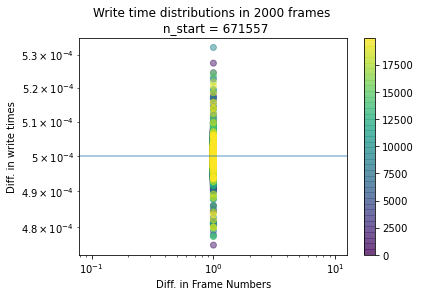

In [5]:
# checking the distribution of the number of files
im = plt.scatter(np.diff(frame_list), np.diff(wrt_list), c=np.arange(len(wrt_list)-1), alpha=0.5)
plt.axhline(1/2000, alpha=0.5)
plt.xlabel('Diff. in Frame Numbers')
plt.ylabel('Diff. in write times')
plt.yscale('log')
plt.xscale('log')
plt.colorbar(im)
plt.title(f'Write time distributions in 2000 frames \n n_start = {n_start}')

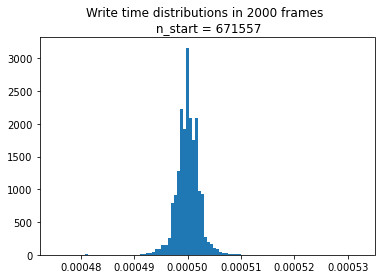

In [6]:
plt.hist(np.diff(wrt_list), bins=100)
plt.title(f'Write time distributions in 2000 frames \n n_start = {n_start}')
plt.show()

=> we do have frame discontinuities between files, but otherwise, follows as expected. There is only one discontinuity in the first 2000, it looks like. But it also seems like a large one

## Normalizing files

1. Subtract Darks
2. Use mask to normalize <br>
    a. multiply pupil mask<br>
    b. divide by sum<br>
    c. multiply by pupil mask
3. Subtract reverence image (flat field)


Notes from Jared:
- also need a dark subtraction
- norm to one inside mask (multiply pupil mask, divide by sum, multiply pupil mask)
- subtraction of the reference image (flat)
- average every other one (two for even vs odd)

In [5]:
# calibration files
calib_path = '../data/calib/'
mask = 'aol1_wfsmask.fits'
ref = 'aol1_wfsref.fits'
dark = 'camwfs-dark_bin2_2000.000000_600.000000_-45.000000__T20220422005142597501326.fits'


### Matrix reductions

All the above reductions, but done in matrix form for speed

In [6]:
# function, takes in data matrix, returns cleaned matrix

def clean_data_cube(data_cube, calib_path, dark, mask, ref):
    dark_data = fits.open(calib_path + dark)[0].data
    mask_data = fits.open(calib_path + mask)[0].data
    ref_data = fits.open(calib_path + ref)[0].data

    dark_mat =  np.repeat(dark_data[np.newaxis, :, :], len(data_cube), axis=0)
    mask_mat =  np.repeat(mask_data[np.newaxis, :, :], len(data_cube), axis=0)
    ref_mat =  np.repeat(ref_data[np.newaxis, :, :], len(data_cube), axis=0)

    mat_dark_sub = data_cube - dark_mat
    mat_normed = np.divide(mat_dark_sub * mask_mat, np.sum(mat_dark_sub * mask_mat, axis=(1,2))[:,None,None])
    # BUG: our ref not 1 normalized, even with the mask, so forcing it to be normal here
    ref_normed = np.divide(ref_mat * mask_mat, np.sum(ref_mat * mask_mat, axis=(1,2))[:,None,None])
    mat_ref_sub = mat_normed - ref_normed
    #mat_ref_sub = mat_normed - ref_mat*mask_mat # if you didn't want the ref normed

    return mat_ref_sub, dark_mat, mask_mat, ref_mat, ref_normed

In [7]:
# splitting into quartiles
def split_data(data_cube):
    arr_s1 = data_cube[::4,:,:]
    arr_s2 = data_cube[1::4,:,:]
    arr_s3 = data_cube[2::4,:,:]
    arr_s4 = data_cube[3::4,:,:]
    return arr_s1, arr_s2, arr_s3, arr_s4

# every four frames, subtract out. 
def split_data_sub(data_cube):
    arr_s1 = data_cube[::4,:,:]
    arr_s2 = data_cube[1::4,:,:]
    arr_s3 = data_cube[2::4,:,:]
    arr_s4 = data_cube[3::4,:,:]
    arr_avg = (arr_s1 + arr_s2 + arr_s3 + arr_s4)/4
    arr_s1 -= arr_avg
    arr_s2 -= arr_avg
    arr_s3 -= arr_avg
    arr_s4 -= arr_avg
    return arr_s1, arr_s2, arr_s3, arr_s4

In [8]:
# Cleaning datacube:
mat_ref_sub, dark_mat, mask_mat, ref_mat, ref_normed = clean_data_cube(data_cube, calib_path, dark, mask, ref)
data_clean = mat_ref_sub

In [11]:
# ex splitting files
#s_arrays = split_data(mat_ref_sub)
s_arrays_clean = split_data_sub(mat_ref_sub)

In [12]:
# Mask but with NAN for np funcitons to ignore
mask_nan = mask_mat.copy()
mask_nan[mask_nan == 0] = np.nan
mask_nan_0 = mask_nan[0,:,:]
# averages
avg_all_data = np.nanmean(mat_ref_sub * mask_nan_0, axis=(0))
avg_split_data = [np.nanmean(si * mask_nan_0, axis=(0)) for si in s_arrays]

<ipython-input-12-69140c60b089>:6: RuntimeWarning: Mean of empty slice
  avg_all_data = np.nanmean(mat_ref_sub * mask_nan_0, axis=(0))
<ipython-input-12-69140c60b089>:7: RuntimeWarning: Mean of empty slice
  avg_split_data = [np.nanmean(si * mask_nan_0, axis=(0)) for si in s_arrays]


### TEST -  frame reductions

This walks through the basic reduction routine for one frame, with key images displayed

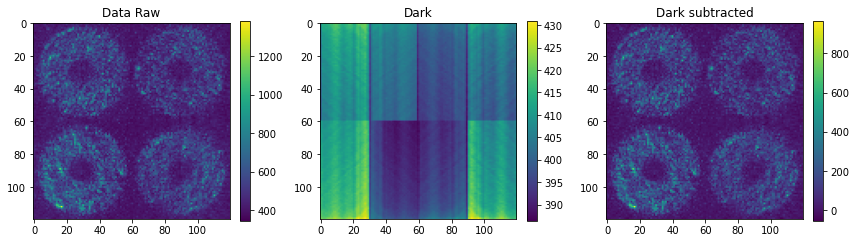

In [13]:
#example, dark subtraction
dark_data = dark_mat[0]
ex_darksub = data_cube[0]-dark_data

plt.figure(1, figsize=(12,6))
plt.subplot(131)
plt.title('Data Raw')
im = plt.imshow(data_cube[0])
plt.colorbar(im, fraction=0.046)

plt.subplot(132)
plt.title('Dark')
im = plt.imshow(dark_data)
plt.colorbar(im, fraction=0.046)

plt.subplot(133)
plt.title('Dark subtracted')
im = plt.imshow(ex_darksub)
plt.colorbar(im, fraction=0.046)

plt.tight_layout()
plt.show()

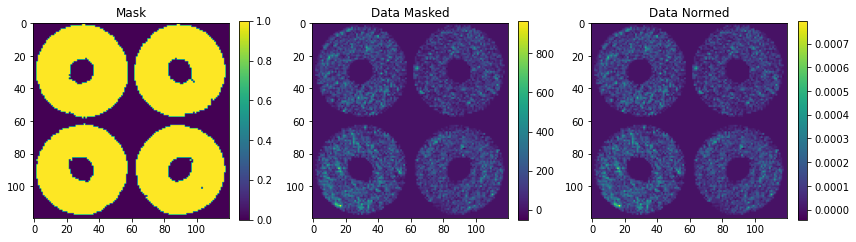

In [14]:
# Example: mask normalization
mask_data = mask_mat[0]
ex_masked = ex_darksub*mask_data
ex_normed = (ex_masked/np.sum(ex_masked))*mask_data

plt.figure(1, figsize=(12,6))
plt.subplot(131)
plt.title('Mask')
im = plt.imshow(mask_data)
plt.colorbar(im, fraction=0.046)

plt.subplot(132)
plt.title('Data Masked')
im = plt.imshow(ex_masked)
plt.colorbar(im, fraction=0.046)

plt.subplot(133)
plt.title('Data Normed')
im = plt.imshow(ex_normed)
plt.colorbar(im, fraction=0.046)

plt.tight_layout()
plt.show()

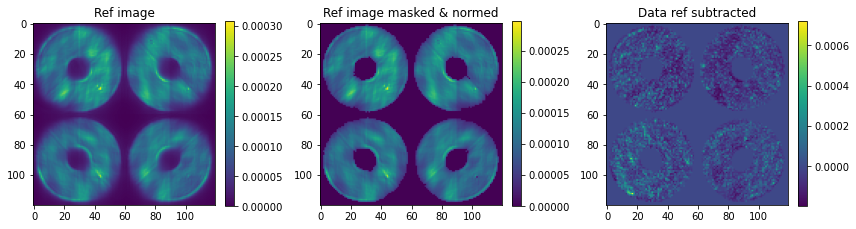

sum of ref image:  1.1344103
sum of ref image, masked:  1.0363946
sum of ref image, masked, normed:  0.99999994


In [20]:
# Example: ref image subtract
ref_data = ref_mat[0]

plt.figure(1, figsize=(12,6))
plt.subplot(131)
plt.title('Ref image')
im = plt.imshow(ref_data)
plt.colorbar(im, fraction=0.046)

plt.subplot(132)
plt.title('Ref image masked & normed')
im = plt.imshow(ref_normed[0])
plt.colorbar(im, fraction=0.046)

plt.subplot(133)
plt.title('Data ref subtracted')
im = plt.imshow(mat_ref_sub[0])
plt.colorbar(im, fraction=0.046)

plt.tight_layout()
plt.show()

print('sum of ref image: ', np.sum(ref_data))
print('sum of ref image, masked: ', np.sum(ref_data*mask_data))
print('sum of ref image, masked, normed: ', np.sum(ref_normed[0]))

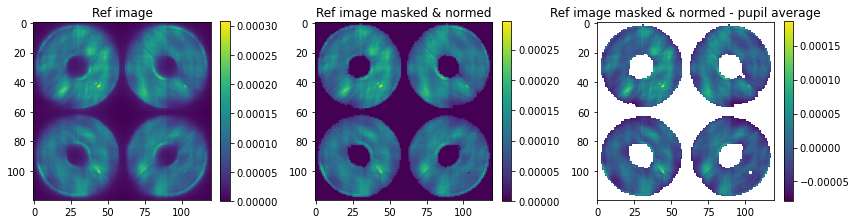

In [67]:
# Example: ref image subtract
ref_data = ref_mat[0]

plt.figure(1, figsize=(12,6))
plt.subplot(131)
plt.title('Ref image')
im = plt.imshow(ref_data)
plt.colorbar(im, fraction=0.046)

plt.subplot(132)
plt.title('Ref image masked & normed')
im = plt.imshow(ref_normed[0])
plt.colorbar(im, fraction=0.046)

plt.subplot(133)
plt.title('Ref image masked & normed - pupil average')
im = plt.imshow(ref_normed[0]*mask_nan_0-np.nanmean(ref_normed[0]*mask_nan_0))
plt.colorbar(im, fraction=0.046)

plt.tight_layout()
plt.show()

Note: the reference image is not a "flat". It is a flat wavefront as seen by the pyramid wavefront sensor. We want to know how our wavefront measurements deviate from the known flat wavefront


clean_data_cube function

### TEST - Matrix redu

In [8]:
# example of cleaning files
data_clean, dark_mat, mask_mat, ref_mat = clean_data_cube(data_cube, calib_path, dark, mask, ref)

In [166]:
# Clean the current datacube
dark_data = fits.open(calib_path + dark)[0].data
mask_data = fits.open(calib_path + mask)[0].data
ref_data = fits.open(calib_path + ref)[0].data

dark_mat =  np.repeat(dark_data[np.newaxis, :, :], len(data_cube), axis=0)
mask_mat =  np.repeat(mask_data[np.newaxis, :, :], len(data_cube), axis=0)
ref_mat =  np.repeat(ref_data[np.newaxis, :, :], len(data_cube), axis=0)

In [142]:
# Matrix version of above cleanup
mat_dark_sub = data_cube - dark_mat
mat_masked = mat_dark_sub * mask_mat
mat_normed = np.divide(mat_masked, np.reshape(np.sum(mat_masked, axis=(1,2)), (len(data_cube),1,1)))
mat_ref_sub = mat_normed * mask_mat - ref_mat * mask_mat

In [149]:
np.sum(mat_masked, axis=(1,2))
np.sum(mat_ref_sub, axis=(1,2))

array([-0.03639453, -0.03639453, -0.03639453, -0.03639454, -0.03639453,
       -0.03639453, -0.03639454, -0.03639453, -0.03639453, -0.03639453,
       -0.03639453, -0.03639453, -0.03639454, -0.03639453, -0.03639453,
       -0.03639453, -0.03639453, -0.03639454, -0.03639464, -0.03639453,
       -0.03639453, -0.03639464, -0.03639454, -0.03639453, -0.03639453,
       -0.03639453, -0.03639454, -0.03639454, -0.03639454, -0.03639453,
       -0.03639454, -0.03639453, -0.03639454, -0.03639453, -0.03639453,
       -0.03639454, -0.03639453, -0.03639454, -0.03639454, -0.03639454,
       -0.03639453, -0.03639453, -0.03639453, -0.03639453, -0.03639453,
       -0.03639453, -0.03639453, -0.03639453, -0.03639453, -0.03639454,
       -0.03639453, -0.03639453, -0.03639454, -0.03639453, -0.03639453,
       -0.03639453, -0.03639453, -0.03639453, -0.03639453, -0.03639453,
       -0.03639454, -0.03639453, -0.03639453, -0.03639454, -0.03639453,
       -0.03639453, -0.03639453, -0.03639453, -0.03639454, -0.03

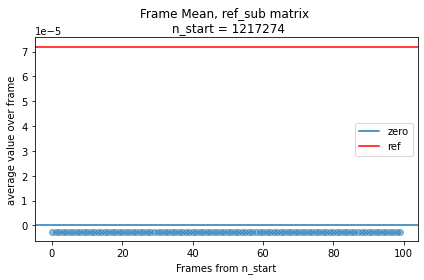

In [143]:
plt.scatter(np.arange(len(mat_ref_sub)), np.mean(mat_ref_sub, axis=(1,2)), alpha = 0.5)
plt.title(f"Frame Mean, ref_sub matrix \n n_start = {n_start}" )
#plt.yscale('log', base=10)
plt.axhline(y=0, label='zero')
plt.axhline(y=np.mean(ref_data*mask_data), label='ref', c='r')
plt.xlabel("Frames from n_start")
plt.ylabel("average value over frame")
plt.tight_layout()
plt.legend()
plt.show()

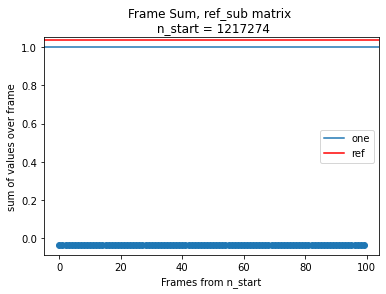

In [144]:
plt.scatter(np.arange(len(mat_ref_sub)), np.sum(mat_ref_sub, axis=(1,2)))
plt.axhline(1, label='one')
plt.axhline(y=np.sum(ref_data*mask_data), label='ref', c='r')
plt.title(f"Frame Sum, ref_sub matrix \n n_start = {n_start}")
plt.xlabel("Frames from n_start")
plt.ylabel("sum of values over frame")
plt.legend()
plt.show()

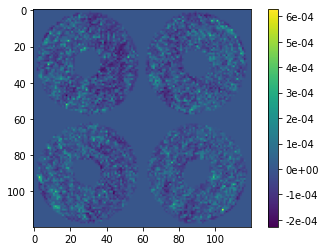

In [145]:
#single image ref sub
im = plt.imshow(mat_ref_sub[0])
plt.colorbar(im, orientation='vertical', format='%.0e')

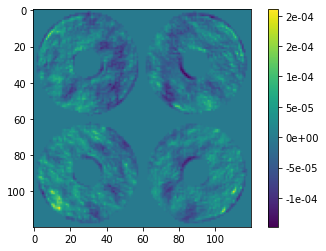

In [126]:
#all average ref sub images
im = plt.imshow(np.mean(mat_ref_sub, axis=0))
plt.colorbar(im, orientation='vertical', format='%.0e')

split data function

## Testing with RMS
- RMS pixel value and mean inside the mask
- average rms of reference frame vs. long term average vs. single frame
- avg and rms of the odd and even frames => should have a higher rms
- if we do see higher rms, speckle pattern may be present


9/6 Jared notes:
- RMS and mean:
    - every frame
    - reference image 
<br>
- whole night average
    - even rms
    - odd rms


In [14]:
# Mask but with NAN for np funcitons to ignore
mask_nan = mask_mat.copy()
mask_nan[mask_nan == 0] = np.nan
mask_nan_0 = mask_nan[0,:,:]

In [29]:
# averages
mask_nan_0 = mask_nan[0,:,:]
avg_all_data = np.nanmean(data_clean * mask_nan_0, axis=(0))
avg_split_data = [np.nanmean(si * mask_nan_0, axis=(0)) for si in s_arrays]

<ipython-input-29-9990ecfe8998>:3: RuntimeWarning: Mean of empty slice
  avg_all_data = np.nanmean(data_clean * mask_nan_0, axis=(0))
<ipython-input-29-9990ecfe8998>:4: RuntimeWarning: Mean of empty slice
  avg_split_data = [np.nanmean(si * mask_nan_0, axis=(0)) for si in s_arrays]


In [29]:
# RMS per frame
avg_masked =  data_clean - np.nanmean(data_clean*mask_nan, axis=(1,2))[:,None,None]
rms_mat = np.nanstd(avg_masked*mask_nan, axis=(1,2))
# RMS for averages
rms_avg = np.nanstd((avg_all_data - np.nanmean(avg_all_data*mask_nan_0))*mask_nan_0)
rms_splits = [np.nanstd((avg_si - np.nanmean(avg_si*mask_nan_0))*mask_nan_0) for avg_si in avg_split_data]

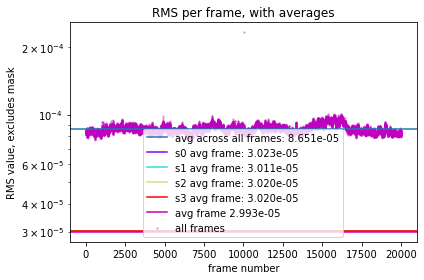

In [32]:
# PLOT: found RMS values
plt.scatter(np.arange(len(rms_mat)), rms_mat, c='m', alpha=0.3, s = 2, label='all frames')
# Define the colors to be used using rainbow map (or any other sequential map)
colors = cm.rainbow(np.linspace(0, 1, 4))
plt.axhline(np.mean(rms_mat), label = f"avg across all frames: {np.mean(rms_mat):0.3e}")
for i in range(4):
    plt.axhline(rms_splits[i], label = f"s{i} avg frame: {rms_splits[i]:0.3e}", c=colors[i])
plt.axhline(rms_avg, label = f"avg frame {rms_avg:0.3e}", c='m')
plt.yscale('log')
plt.ylabel('RMS value, excludes mask')
plt.xlabel('frame number')
plt.legend()
plt.title('RMS per frame, with averages')
plt.tight_layout()
plt.show()

In [26]:
# mean value per frame 
mean_all = np.nanmean(data_clean*mask_nan, axis=(1,2))[:,None,None]
mean_avg = np.nanmean(avg_all_data*mask_nan_0)
mean_splits = [np.nanmean(avg_si*mask_nan_0) for avg_si in avg_split_data]

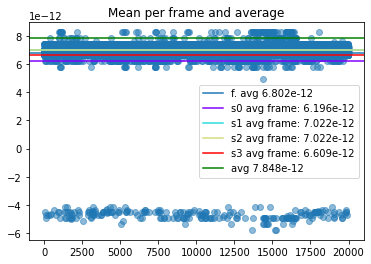

In [33]:
# PLOT: Mean values for all
plt.scatter(np.arange(len(mean_all)), mean_all[:,0,0], alpha = 0.5)
plt.axhline(np.mean(mean_all), label = f"f. avg {np.mean(mean_all):0.3e}")
# averages over splits
for i in range(4):
    plt.axhline(mean_splits[i], label = f"s{i} avg frame: {mean_splits[i]:0.3e}", c=colors[i])
plt.axhline(mean_avg, label = f"avg {mean_avg:0.3e}", c='g')
#plt.yscale('log')
plt.legend()
plt.title('Mean per frame and average')
plt.show()

### Correlations

looking to see if we can see the shifts between the various spatial phase offsets. 

In [61]:
# Correlating the averages:
from scipy import signal

avg_split_data = np.array(avg_split_data)
avg_split_data[np.isnan(avg_split_data)] = 0
avg_all_data[np.isnan(avg_all_data)] = 0

corr = [[signal.correlate2d(ii-avg_all_data, jj-avg_all_data, boundary='symm', mode='same') for ii in avg_split_data] for jj in avg_split_data]

In [62]:
# determining index max for the array

for i in range(4):
    for j in range(4):
        idx_corr = np.argmax(corr[i][j])
        idx_pair = np.unravel_index(np.argmax(corr[i][j]), np.array(corr[i][j]).shape)
        print(f"Corr Max of Spit {i} and {j} is: {idx_pair}")


Corr Max of Spit 0 and 0 is: (59, 59)
Corr Max of Spit 0 and 1 is: (58, 62)
Corr Max of Spit 0 and 2 is: (55, 56)
Corr Max of Spit 0 and 3 is: (56, 53)
Corr Max of Spit 1 and 0 is: (60, 56)
Corr Max of Spit 1 and 1 is: (59, 59)
Corr Max of Spit 1 and 2 is: (56, 53)
Corr Max of Spit 1 and 3 is: (64, 61)
Corr Max of Spit 2 and 0 is: (63, 62)
Corr Max of Spit 2 and 1 is: (62, 65)
Corr Max of Spit 2 and 2 is: (59, 59)
Corr Max of Spit 2 and 3 is: (60, 56)
Corr Max of Spit 3 and 0 is: (62, 65)
Corr Max of Spit 3 and 1 is: (54, 57)
Corr Max of Spit 3 and 2 is: (58, 62)
Corr Max of Spit 3 and 3 is: (59, 59)


<Figure size 1152x1152 with 0 Axes>

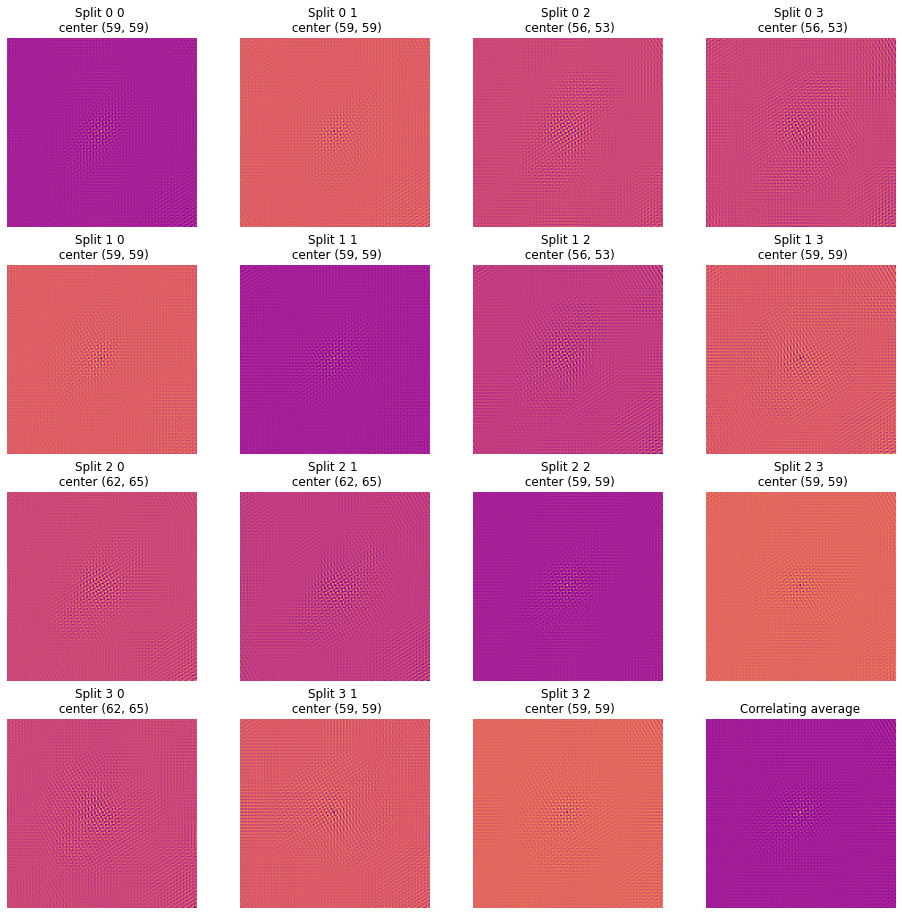

In [65]:
# showing averages of the quartile split:
fig, axs = plt.subplots(4, 4, figsize=(16,16))

for i in range(4):
    for j in range(4):
        axs[i][j].set_title(f'Split {i} {j} \n center {np.unravel_index(np.argmax(np.abs(corr[i][j])), np.array(corr[i][j]).shape)}')
        axs[i][j].imshow(corr[i][j], cmap = 'plasma')
        axs[i][j].axis('off')

plt.title("Correlating average")
plt.show()


## Pearson Correlation Coefficient 

Want to know how related we are to the reference image in our residual background

In [53]:
def pearson_coeff(im1, im2, mask_nan):
    im1 = (im1*mask_nan).flatten()
    im2 = (im2*mask_nan).flatten()
    covar = np.nansum((im1 - np.nanmean(im1))*(im2 - np.nanmean(im2)))/(len(im1) - 1)
    std_prod = np.nanstd(im1) * np.nanstd(im2)
    return covar / std_prod

In [54]:
# subtracting average value in four pupils:
p_coeffs_ref = [pearson_coeff(frame, ref_mat[0], mask_nan_0) for frame in mat_ref_sub]

[]

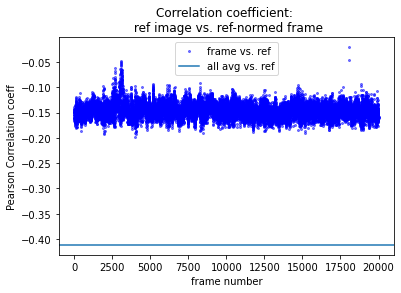

In [56]:
plt.figure(facecolor='white')
plt.plot(p_coeffs_ref, 'bo', alpha = 0.5, markersize=2, label='frame vs. ref')
plt.axhline(pearson_coeff(avg_all_data, ref_mat[0], mask_nan_0), label='all avg vs. ref')
plt.xlabel('frame number')
plt.ylabel('Pearson Correlation coeff')
plt.title('Correlation coefficient: \n ref image vs. ref-normed frame')
plt.legend()
plt.plot(transparent=False)

## measuring modal amplitude

In [55]:
# dot product of the average with each individual frame
s_mean_clean = np.nanmean(s_arrays_clean, axis=1)
s_mean_clean_norm = np.array([avg_split/np.linalg.norm(avg_split.flatten())for avg_split in s_mean_clean])

c_mat1 = np.array([[np.dot(s_mean_clean_norm[e].flatten(), array.flatten()) for array in split] for e, split in enumerate(s_arrays_clean)])


In [56]:
c_mat1 = np.array(c_mat1)
c_mat1.shape

[np.dot(s_mean.flatten(), s_mean.flatten()) for s_mean in s_mean_clean_norm] 

[1.0000001, 1.0, 1.0, 1.0]

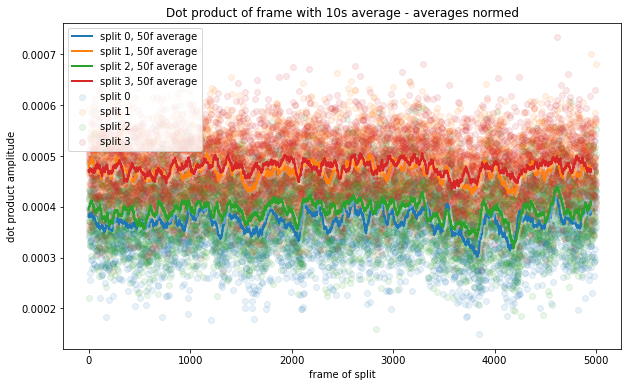

In [86]:
import matplotlib.patheffects as pe
fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(c_mat1):
    plt.scatter(np.arange(len(mat)), mat, alpha = 0.1, label = f'split {e}')
for e, mat in enumerate(c_mat1):
    plt.plot(dot_avgs2[e], lw=2, label = f'split {e}, 50f average', path_effects=[pe.SimpleLineShadow(shadow_color='w'), pe.Normal()])

plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title("Dot product of frame with 10s average - averages normed")
plt.show()

In [117]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def moving_stdv(a, n=3):
    ret = np.array([np.std(a[i:i+n]) for i in np.arange(len(a-n))])
    return ret[:-n+1]

dot_avgs2 = np.array([moving_average(dot, n=100) for dot in c_mat1])
dot_stds = np.array([moving_stdv(dot, n=100) for dot in c_mat1])

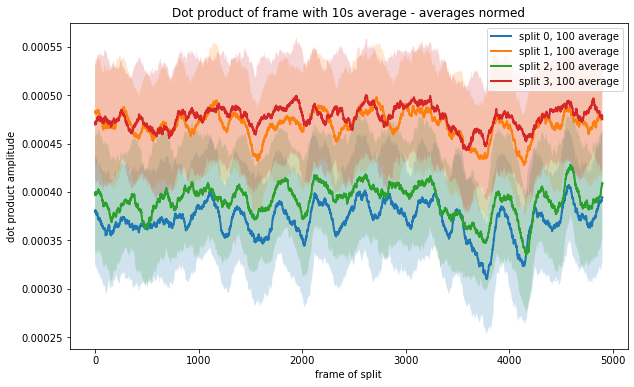

In [118]:
fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(c_mat1):
    plt.plot(dot_avgs2[e], lw=2, label = f'split {e}, 100 average')
    plt.fill_between(np.arange(len(dot_avgs2[e])), dot_avgs2[e]-dot_stds[e], dot_avgs2[e]+dot_stds[e], alpha=0.2)

plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title("Dot product of frame with 10s average - averages normed")
plt.show()

In [78]:
dot_avgs2.shape

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Dot product of frame with 10s average - averages normed')

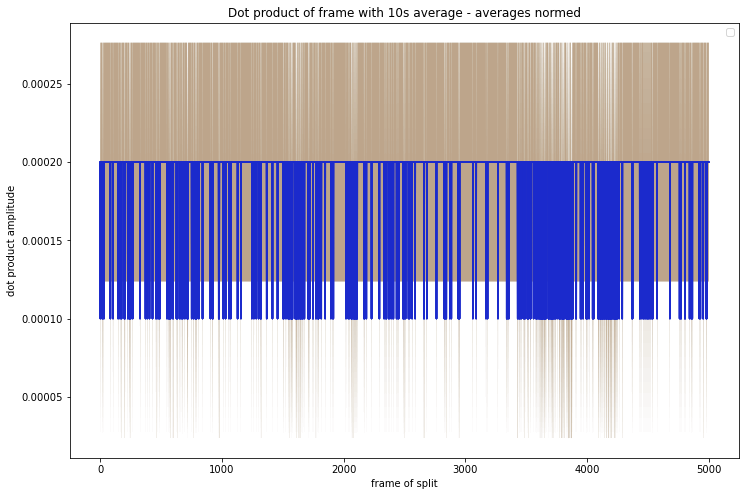

In [74]:
# Plotting rolling average
fig = plt.figure(figsize=(12,8), facecolor='white')

for e, davg in enumerate(dot_avgs):
    y = davg  
    x = np.arange(len(y)) 
    error = dot_stdvs[e]

    plt.plot(x, y, 'k', color='#1B2ACC')
    plt.fill_between(x, y-error, y+error,
        alpha=0.2)

plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title("Dot product of frame with 10s average - averages normed")

## Displaying
check out https://github.com/magao-x/MagAOX/blob/dev/scripts/obs_to_movie

General requests:
- animate all frames, raw and processed
- animate even and odd frames
- blink between a 10s chunk average. for different points in the daa collected

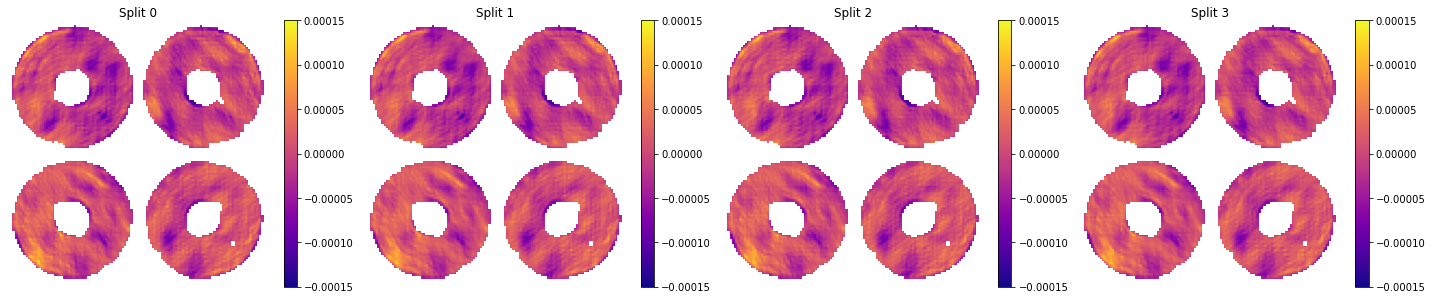

In [13]:
# showing averages of the quartile split:
fig = plt.figure(figsize=(20,6))

vmax = np.max(avg_split_data)
vmin = np.min(avg_split_data)

for i in range(4):
    ax = plt.subplot(141+i)
    plt.title(f'Split {i}')
    im = plt.imshow(avg_split_data[i]*mask_nan_0, vmax=0.00015, vmin=-0.00015, cmap = 'plasma')
    plt.colorbar(im, fraction=0.046)
    plt.axis('off')
plt.tight_layout()
plt.show()


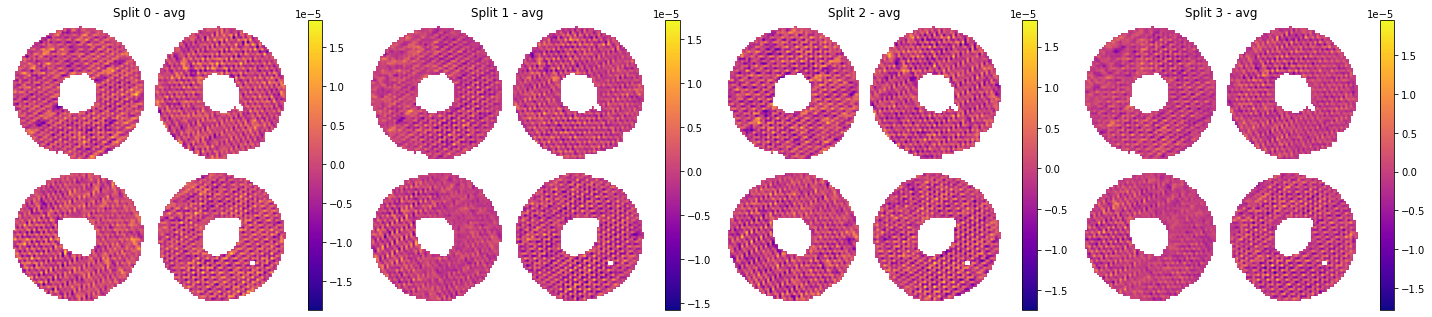

In [14]:
# showing averages minust the overall average of the quartile split:
fig = plt.figure(figsize=(20,6))

for i in range(4):
    ax = plt.subplot(141+i)
    plt.title(f'Split {i} - avg')
    im = plt.imshow((avg_split_data[i]-avg_all_data)*mask_nan_0, cmap = 'plasma')
    plt.colorbar(im, fraction=0.046)
    plt.axis('off')
plt.tight_layout()
plt.show()

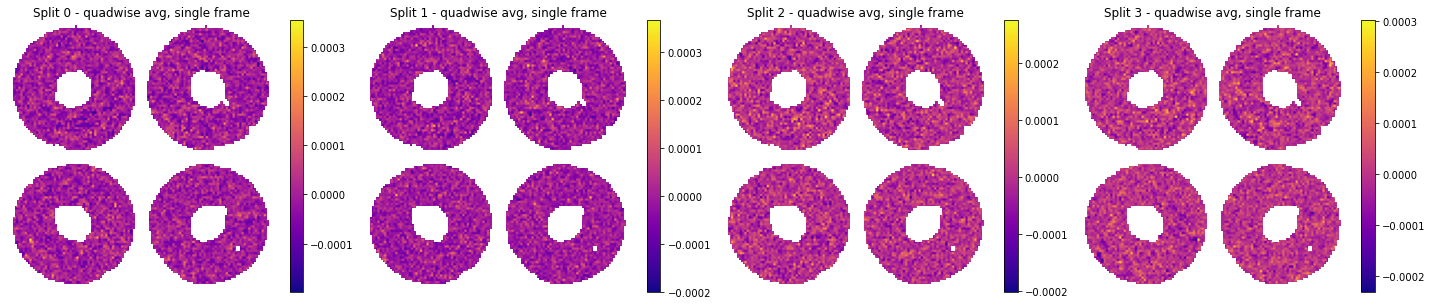

In [29]:
# new method, self subtrating in quads
fig = plt.figure(figsize=(20,6), facecolor='white')

for i in range(4):
    ax = plt.subplot(141+i)
    plt.title(f'Split {i} - quadwise avg, single frame')
    im = plt.imshow(s_arrays_clean[i][0]*mask_nan_0, cmap = 'plasma')
    plt.colorbar(im, fraction=0.046)
    plt.axis('off')
plt.tight_layout()
plt.show()

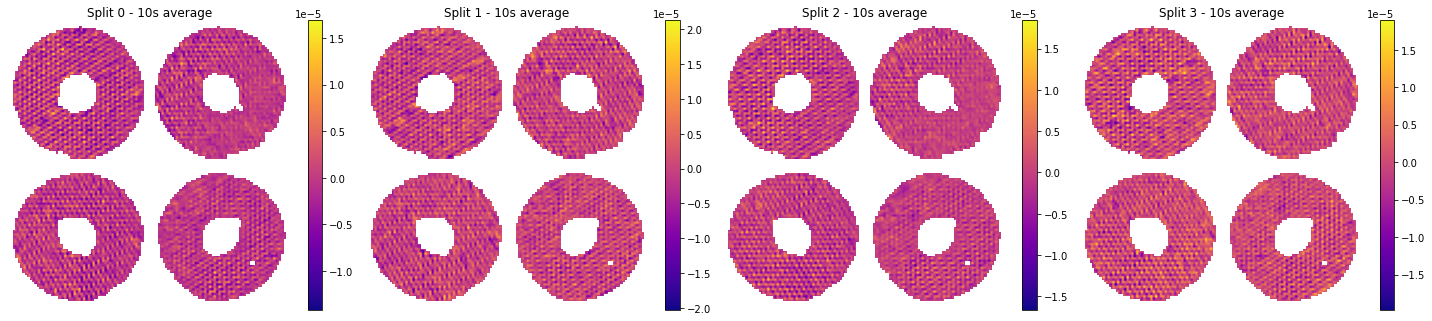

In [87]:
# new method, average
fig = plt.figure(figsize=(20,6), facecolor='white')

for i in range(4):
    ax = plt.subplot(141+i)
    plt.title(f'Split {i} - 10s average')
    im = plt.imshow(np.nanmean(s_arrays_clean[i], axis=0)*mask_nan_0, cmap = 'plasma')
    plt.colorbar(im, fraction=0.046)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [49]:
# comparing RMS of the different subtractions
n_list = np.arange(-2, 2, 0.001)
sub_list = [ref_masked - n*avg_masked for n in n_list]
rms_list = [np.nanstd((data_sub - np.nanmean(data_sub))*mask_nan_0) for data_sub in sub_list]
min_n = n_list[np.argmin(rms_list)]
min_rms = np.min(rms_list)

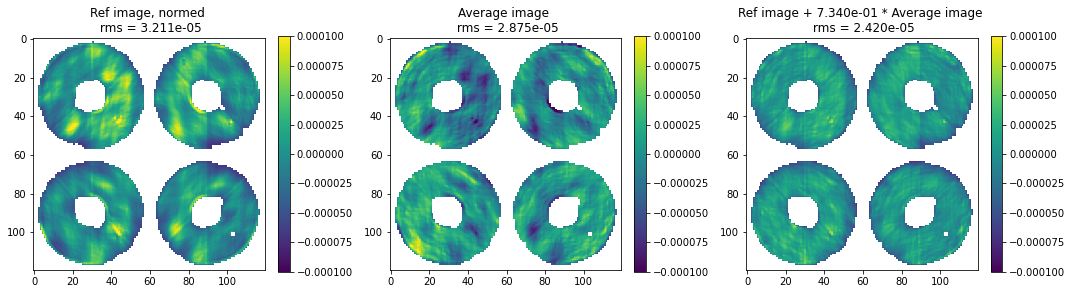

In [48]:
# average vs. ref image
plt.figure(1, figsize=(15,6), facecolor='white')

ref_masked = ref_normed[0]* mask_nan_0 - np.nanmean(ref_normed[0]* mask_nan_0)
avg_masked = avg_all_data *mask_nan_0 - np.nanmean(avg_all_data *mask_nan_0)

rms_avg = np.nanstd((avg_masked - np.nanmean(avg_masked)))
rms_ref = np.nanstd((ref_masked - np.nanmean(ref_masked)))

data_sub = ref_masked - min_n*avg_masked
rms_sub = np.nanstd((data_sub - np.nanmean(data_sub))*mask_nan_0)

vmin = -1e-4
vmax = 1e-4

plt.subplot(131)
plt.title(f'Ref image, normed \n rms = {rms_ref:0.3e}')
im = plt.imshow(ref_masked, vmin=vmin, vmax=vmax)
plt.colorbar(im, fraction=0.046)

plt.subplot(132)
plt.title(f'Average image \n rms = {rms_avg:0.3e}')
im = plt.imshow(avg_masked, vmin=vmin, vmax=vmax)
plt.colorbar(im, fraction=0.046)

plt.subplot(133)
plt.title(f'Ref image + {-min_n:0.3e} * Average image \n rms = {rms_sub:0.3e}')
im = plt.imshow(data_sub - np.nanmean(data_sub), vmin=vmin, vmax=vmax)
plt.colorbar(im, fraction=0.046)

plt.tight_layout()
plt.show()

### Animations

In [33]:
# Animate: subtract last four frame average
file_name = 'plts/animated_frames'
plot_title = "4 way split - frame animated"
cmap = 'plasma'

# from git code
temp_dir = tempfile.TemporaryDirectory()
temp_dir_path = temp_dir.name
os.makedirs(temp_dir_path, exist_ok=True)

# generating frames
vmin =  -3e-4 #np.min(s_arrays_clean)
vmax =  3e-4 #np.max(s_arrays_clean)

scale_kwargs = {'vmin': vmin, 'vmax': vmax}

for idx in np.arange(40):
    fig = plt.figure(figsize=(20,6), facecolor='white')
    for i in range(4):
        ax = plt.subplot(141+i)
        plt.title(f'Split {i} - quadwise avg, single frame')
        im = plt.imshow(s_arrays_clean[i][idx]*mask_nan_0, cmap=cmap, **scale_kwargs)
        plt.colorbar(im, fraction=0.046)
        plt.axis('off')
    plt.title(plot_title)
    plt.tight_layout()
    plt.savefig(temp_dir_path + f'/frame_{idx:08}.png', dpi=150) # 200 took 19s for 20 frames
    plt.close()

with imageio.get_writer(file_name+'.gif', mode='i', fps=4) as writer:
    for i in range(2, idx+1):
        image = imageio.imread(temp_dir_path + f'/frame_{i:08}.png')
        writer.append_data(image)
temp_dir.cleanup()

In [ ]:
#Aanimate: subtract running average?

In [31]:
# animate all frames
#flipping animation cod

file_name = 'plts/data_flip'
plot_title = "ODD vs EVEN average"
cmap = 'plasma'

# from git code
temp_dir = tempfile.TemporaryDirectory()
temp_dir_path = temp_dir.name
os.makedirs(temp_dir_path, exist_ok=True)

# generating frames
vmin = np.min(data)
vmax = np.max(data)

scale_kwargs = {'vmin': vmin, 'vmax': vmax}

for idx, img in enumerate(data):
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(img,
                cmap=cmap,
                **scale_kwargs)
    fig.colorbar(im, shrink=0.6)
    plt.title(plot_title)
    plt.tight_layout()
    plt.savefig(temp_dir_path + f'/frame_{idx:08}.png', dpi=150) # 200 took 19s for 20 frames
    plt.close()

with imageio.get_writer(file_name+'.gif', mode='i', fps=2) as writer:
    for i in range(2, idx+1):
        image = imageio.imread(temp_dir_path + f'/frame_{i:08}.png')
        writer.append_data(image)
temp_dir.cleanup()


NameError: name 'data' is not defined

In [71]:
# blink between a 10s chunk average, for different points in the data collected


In [66]:
# General animation code
# inspired by MAGAO-X code

data = data_cube[:100, :, :]
file_name = 'plts/data_raw'
plot_title = "RAW Frames all"
cmap = 'plasma'

# from git code
temp_dir = tempfile.TemporaryDirectory()
temp_dir_path = temp_dir.name
os.makedirs(temp_dir_path, exist_ok=True)

# generating frames
vmin = np.min(data)
vmax = np.max(data)
scale_kwargs = {'vmin': vmin, 'vmax': vmax}

for idx, img in enumerate(data):
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(img,
                cmap=cmap,
                **scale_kwargs)
    fig.colorbar(im, shrink=0.6)
    plt.title(plot_title)
    plt.tight_layout()
    plt.savefig(temp_dir_path + f'/frame_{idx:08}.png', dpi=150) # 200 took 19s for 20 frames
    plt.close()

with imageio.get_writer(file_name+'.gif', mode='i', fps=4) as writer:
    for i in range(2, idx+1):
        image = imageio.imread(temp_dir_path + f'/frame_{i:08}.png')
        writer.append_data(image)

temp_dir.cleanup()

In [70]:
#flipping animation cod
data = np.repeat([avg_odd_data, avg_even_data], 50, axis=0)
file_name = 'plts/data_flip'
plot_title = "ODD vs EVEN average"
cmap = 'plasma'

# from git code
temp_dir = tempfile.TemporaryDirectory()
temp_dir_path = temp_dir.name
os.makedirs(temp_dir_path, exist_ok=True)

# generating frames
vmin = np.min(data)
vmax = np.max(data)
scale_kwargs = {'vmin': vmin, 'vmax': vmax}

for idx, img in enumerate(data):
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(img,
                cmap=cmap,
                **scale_kwargs)
    fig.colorbar(im, shrink=0.6)
    plt.title(plot_title)
    plt.tight_layout()
    plt.savefig(temp_dir_path + f'/frame_{idx:08}.png', dpi=150) # 200 took 19s for 20 frames
    plt.close()

with imageio.get_writer(file_name+'.gif', mode='i', fps=2) as writer:
    for i in range(2, idx+1):
        image = imageio.imread(temp_dir_path + f'/frame_{i:08}.png')
        writer.append_data(image)
temp_dir.cleanup()

In [ ]:
# try 10 seconds of data

# animate the raw frames -> should see modulation
# animate seperated raw frames
# blink the averages -> see the coherent pattern shifting

# average of all frames should be zero after the ref sub


# sample first/ middle / end quarter

## Backgrounds